Write a memo discussing power and study design for the following
situation.  A researcher wishes to evaluate the factors that will predict whether students
in an on-line course complete more quizzes.  The course involves 10 quizzes, and a student
has probability
$p(x, z, j) = 1 / (1 + \exp(-\beta_0 - \beta_1x - \beta_2z - \beta_3j - \beta_4xj))$
of completing the $j^{\rm th}$ quiz, for $j=1, \ldots, 10$,
where $x$ and $z$ are covariates.  The covariates can be taken to be marginally
standardized, and the correlation between them is $r_{xz}$.  It is anticipated
that students are less likely to complete the quizzes that occur later in the course
(larger values of $j$).  The key research question is whether the characteristic
measured by $x$ is associated with steeper decline in $p(x, z, j)$ with increasing $j$.
There are two additional factors to consider.  First, the response data $y_{ij}$
(the indicator that student $i$ completes quiz $j$) are correlated, but little
is known about the strength of correlation.  Second,
each student drops out of the course after taking quiz $j$ with probability $q_j$
(after dropping out of the course, the student will not take any more quizzes).  It
is expected that $q_j$ is increasing in $j$ and the probability of not dropping out
at all should be around $0.5$.

- Logistic regression is used to model the probability that a student completes quiz $j$
- $x$ and $z$ are the only co-variates
- $x$ and $z$ are both separately standardized
- $x$ and $z$ are correlated ($r_{xz}$)
- It is anticipated that $p(x, z, j)$ will decrease as $j$ increases, i.e. students are more likely to not do later quizzes in the course
- This study was made in order to understand if the values of $x$ cause a sharper decline in $p$ as $j$ increases (we are interested in $\beta_4$)
- The response data is a matrix $Y_{ij}$ with indicator entries showing if student $i$ completed quiz $j$
- The columns in $Y$ are correlated but little is known about that
- Each student drops out of the course after taking quiz $j$ with probability $q_j$ and no data for that student is present after that
- $q_j$ is expected to increase in $j$ and the probability of not dropping at all is $0.5$ i.e. $P(\text{drop}_1 = 0, \cdots, \text{drop}_{10} = 0) = 0.5$
- The only role of $q_j$ is to delete data, after a student drops no further data is available.
- It is needed to condition that $q_{j+1} > q_{j}$ and to satisfy the $0.5$ constraint $\prod_1^9(1-q_j \cdot \epsilon) \approx 0.5$
- It is expected that $\beta_3$ and $\beta_4$ are negative

Things to explore to see their effect on power:

- Sample size
- Correlation between $x,z$
- Correlation among $y_i$
- Different solutions $q_j$ (not that interesting)
- Different true values of the betas (focus on the interaction term)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import norm, binom, logistic

# Produce qs that go according to specification
qs_prime = np.array([(1-0.01465*i) for i in range(1, 10)])
qs = 1 - qs_prime

def gen_correlated_xz(n: int, corr: float, seed: int) -> np.ndarray:
    '''Generate n correlated standard normal x,z.

    Args:
        n (int): Number of observations.
        corr (float): Correlation between x and z.
        seed (int): Seed to use in the random generator.

    Returns:
        A (n, 2) shaped array containing x and z.
    '''
    rng = np.random.default_rng(seed)
    r = np.full((2, 2), corr)
    np.fill_diagonal(r, 1)
    return rng.multivariate_normal(mean=np.zeros(2), cov=r, size=n)


def gen_drop_indicators(n: int, seed: int) -> np.ndarray:
    '''Use q_j to see the quiz j after which each of n students drops out, if any.

    Args:
        n (int): Number of students to simulate.
        seed (int): Seed to use in the random generator.
    
    Returns:
        A (n, 1) shaped array containing -1 if the student does not drop the course or
        an integer representing the last quiz the student took.
    '''
    rng = np.random.default_rng(seed)
    result = np.full(n, np.inf)
    for student in range(n):
        for i, q in enumerate(qs):
            if rng.binomial(1, q):
                result[student] = i + 1
    result = result.reshape((n, 1))
    return result


def p_quiz_j(x: np.ndarray, z: np.ndarray, b: np.ndarray) -> np.ndarray:
    '''Calculate p(x, z, j) given a vector b of betas

    Args:
        x (NDArray): Vector with x values for each student.
        z (NDArray): Vector with z values for each student.
        b (NDArray): Vector with beta coefficients.

    Returns:
        NDArray: A (n, 10) shaped array showing p(x, z, j) given b. Each
        row represents a different student and each column a different quiz.
    '''
    result = np.empty((x.shape[0], 10))
    for j in range(1, 11):
        mn_prime = -(b[0] + b[1]*x + b[2]*z + b[3]*j + b[4]*x*j)
        mn = logistic.cdf(mn_prime)
        result[:, j-1] = mn
    return result


def gen_correlated_ys(ps: np.ndarray, corr: float, seed: int) -> np.ndarray:
    '''Generates 10 correlated bernoulli observations given different students' p vectors.

    Args:
        ps (int): Array containing p(x, z, j) for different students.
        corr (float): Correlation among all pairs of y.
        seed (int): Seed to use in the random generator.

    Returns:
        A (n, 10) shaped array representing the indicator variables of each quiz for different students.
    '''
    # Generate correlated standard normal variables
    rng = np.random.default_rng(seed)
    r = np.full((10, 10), corr)
    np.fill_diagonal(r, 1)
    normals = rng.multivariate_normal(
        mean=np.zeros(10), cov=r, size=ps.shape[0])

    # Use copula to translate to binomial
    u = norm.cdf(normals)
    return binom.ppf(u, 1, ps)


def generate_data(n: int, corr_1: float, corr_2: float, b: np.ndarray, seed: int):
    '''Generate student values based on the assumed model and setting.

    Args:
        n (int): Generate data for n students.
        corr_1 (float): Correlation between x and z.
        corr_2 (float): Correlation to generate dependent pairs of y_i.
        b (NDArray): Vector with beta coefficients.
        seed (int): Random seed.
    
    Returns:
        NDArray containing the generated data.
    '''
    # Generate values
    da = gen_correlated_xz(n, corr_1, seed)
    x = da[:, 0]
    z = da[:, 1]
    ps = p_quiz_j(x, z, b)
    ys = gen_correlated_ys(ps, corr_2, seed)
    ys = ys.flatten().reshape((ys.size, 1))

    # Combine into a data frame
    generated = pd.DataFrame(np.hstack((
        np.repeat(np.array([i for i in range(n)]),
                  repeats=10, axis=0).reshape((n*10, 1)),
        np.array([i % 10 + 1 for i in range(n*10)]).reshape((n*10, 1)),
        ys.flatten().reshape((n*10, 1)),
        np.repeat(da, repeats=10, axis=0),
        np.repeat(gen_drop_indicators(n, 1), repeats=10, axis=0)
    ))
    )

    # Change column names and remove y values after a student drops the course
    generated.columns = ['student_id', 'j', 'y', 'x', 'z', 'last_quiz']
    generated.loc[generated.j > generated.last_quiz, 'y'] = np.NaN
    return generated


def estimate_power(N: int, alpha: float, n: int, corr_1: float, corr_2: float, b: np.ndarray, seed: int):
    '''Estimate the power for a given setup of parameters. In this context, we are interested b[4].

    Args:
        N (int): Estimate based on N repetitions.
        alpha (float): Control type I errors at a level of alpha.
        n (int): Generate data for n students.
        corr_1 (float): Correlation between x and z.
        corr_2 (float): Correlation to generate dependent pairs of y_i.
        b (NDArray): Vector with beta coefficients.
        seed (int): Random seed.
    
    Returns:
        The estimated power for this particular setup.
    '''

    # Random generator to generate seeds for each of the repetitions
    rand_gen = np.random.default_rng(seed=seed)
    seeds = rand_gen.integers(1, 10000, N)

    # Check for type II errors
    type_2_errors = np.empty(N)
    for error_index, s in enumerate(seeds):
        d = generate_data(n, corr_1, corr_2, b, s)
        d = d.dropna()
        log_reg = smf.logit('y ~ x + z + j + x*j', data=d).fit(disp=False)
        type_2_errors[error_index] = log_reg.pvalues[4] > alpha
    
    # Calculate power
    type_2_error_rate = np.mean(type_2_errors)
    power = 1 - type_2_error_rate
    return power

## Analysis

In [ ]:
# Generate data example
d = generate_data(500, 0.4, 0.7, np.array([1, 2, 3, -0.3, -0.001]), 3)
d = d.dropna()
d = d.reset_index(drop = True)
# print(d)

In [3]:
# Estimate power through different values of r_{xz}
rs = np.array([-1 + (i + 1)*0.05 for i in range(39)])
powers_r_xz = np.empty(39)

for i, r in enumerate(rs):
    powers_r_xz [i] = estimate_power(100, 0.05, 100, r, 0.7, np.array([1, 2, 3, -0.3, -0.2]), 1)


In [4]:
# Estimate power through different correlations among y_j
powers_y_r = np.empty(39)

for i, r in enumerate(rs):
    powers_y_r[i] = estimate_power(100, 0.05, 100, 0.4, r, np.array([1, 2, 3, -0.3, -0.2]), 1)


/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(
/tmp/ipykernel_30166/2784467602.py:83: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  normals = rng.multivariate_normal(

In [ ]:
# Estimate power through different sample sizes
ns = [i+50 for i in range(71)]
powers_n = np.empty(71)

for i, n in enumerate(ns):
    powers_n[i] = estimate_power(100, 0.05, n, 0.4, 0.7, np.array([1, 2, 3, -0.3, -0.2]), 1)


In [ ]:
# Estimate power through different values of beta_4
betas_4= [-8 + 0.1*i for i in range(80)]
powers_beta_4 = np.empty(80)

for i, b_4 in enumerate(betas_4):
    powers_beta_4[i] = estimate_power(100, 0.05, 100, 0.4, 0.7, np.array([1, 2, 3, -0.3, b_4]), 1)


In [ ]:
# Estimate power through different values of beta_3
betas_3= [-8 + 0.1*i for i in range(80)]
powers_beta_3 = np.empty(80)

for i, b_3 in enumerate(betas_3):
    powers_beta_3[i] = estimate_power(100, 0.05, 100, 0.4, 0.7, np.array([1, 2, 3, b_3, -0.4]), 1)


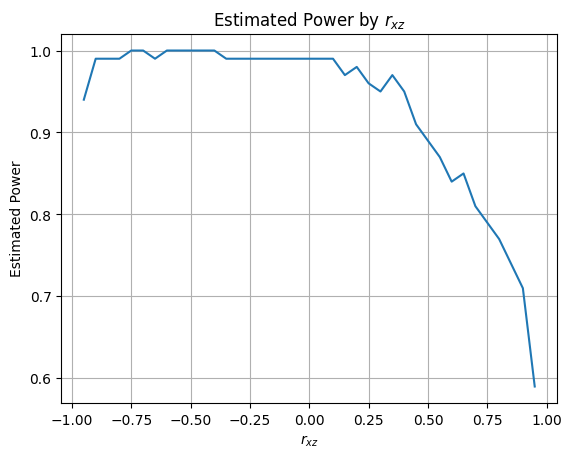

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# r_xz effect on power plot
sns.lineplot(pd.DataFrame(powers_r_xz, rs), legend=None)
fig = plt.figure(1)
plt.xlabel(r'$r_{xz}$')
plt.ylabel('Estimated Power')
plt.title(r'Estimated Power by $r_{xz}$')
plt.grid()
plt.savefig('img/1.png')


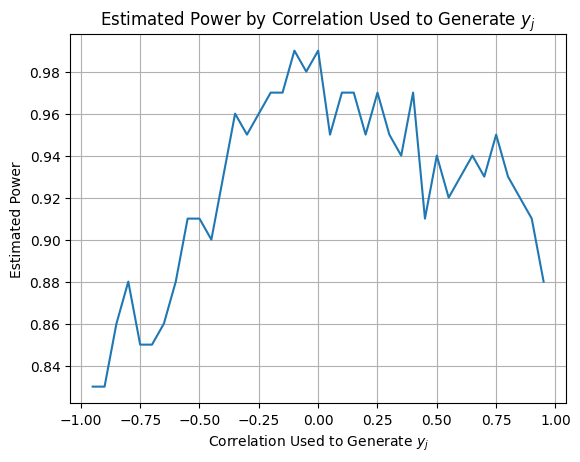

In [7]:
# Correlation among y_i effect on power plot
sns.lineplot(pd.DataFrame(powers_y_r, rs), legend=None)
fig = plt.figure(1)
plt.xlabel(r'Correlation Used to Generate $y_j$')
plt.ylabel('Estimated Power')
plt.title(r'Estimated Power by Correlation Used to Generate $y_j$')
plt.grid()
plt.savefig('img/2.png')


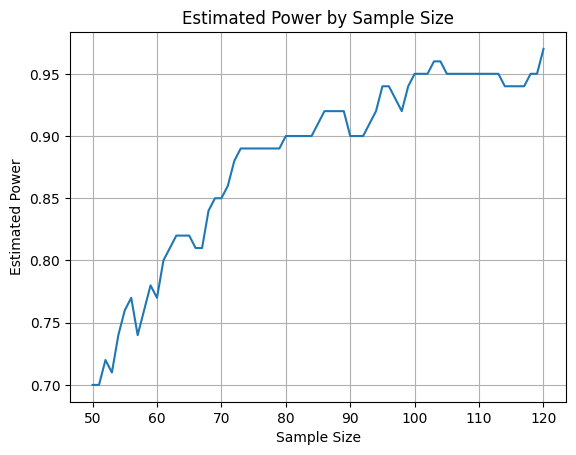

In [99]:
# Estimated power for different sample sizes
sns.lineplot(pd.DataFrame(powers_n, ns), legend=None)
fig = plt.figure(1)
plt.xlabel(r'Sample Size')
plt.ylabel('Estimated Power')
plt.title(r'Estimated Power by Sample Size')
plt.grid()
plt.savefig('img/3.png')


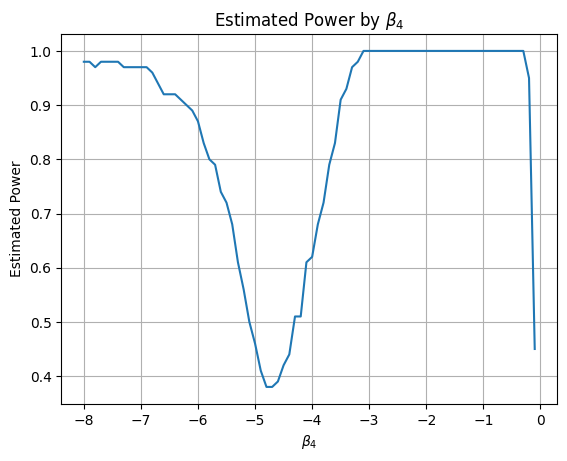

In [101]:
# Estimated power for different values of beta_4
sns.lineplot(pd.DataFrame(powers_beta_4, betas_4), legend=None)
fig = plt.figure(1)
plt.xlabel(r'$\beta_4$')
plt.ylabel('Estimated Power')
plt.title(r'Estimated Power by $\beta_4$')
plt.grid()
plt.savefig('img/4.png')


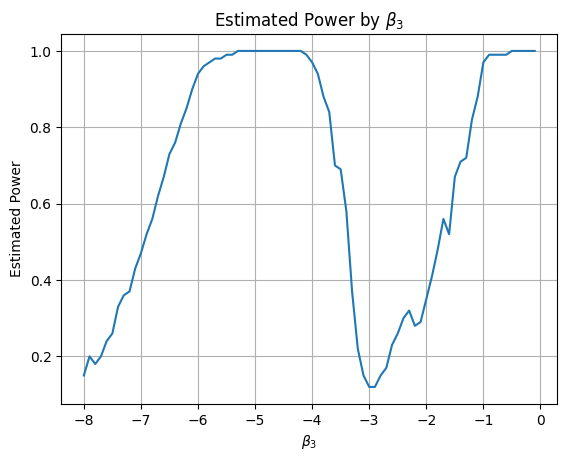

In [104]:
# Estimated power for different values of beta_3
sns.lineplot(pd.DataFrame(powers_beta_3, betas_3), legend=None)
fig = plt.figure(1)
plt.xlabel(r'$\beta_3$')
plt.ylabel('Estimated Power')
plt.title(r'Estimated Power by $\beta_3$')
plt.grid()
plt.savefig('img/5.png')
